# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [ ]:
import tensorflow as tf
import time
import keras
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.dataset import load_dataset_windowed

# GPU memory growth setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Seed and logging
keras.utils.set_random_seed(812)
logging.getLogger().setLevel(logging.WARNING)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-5
)


# ===== DATA LOADING =====
def remove_elevation_features(input_dict, label):
    input_dict['geospatial'] = input_dict['geospatial'][..., 2:]  # Keep channels 2-8
    return input_dict, label

timestamp = time.strftime("%Y%m%d-%H%M%S")
sim_names = ["Atlanta-Atlanta_config/Rainfall_Data_1.txt"]

# Grab only the first 3 samples
train_dataset_full = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=1,
    dataset_split='train'
).map(remove_elevation_features)

for i, (x, y) in enumerate(train_dataset_full.take(20)):
    if tf.reduce_mean(y).numpy() > 0.001:
        print(f"Sample {i} has mean flood depth {tf.reduce_mean(y).numpy():.4f}")
train_dataset = train_dataset_full.skip(19).take(1).cache().repeat()

validation_data = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=1,
    dataset_split='val'
).map(remove_elevation_features).take(3).cache()

constants.GEO_FEATURES = 7

# ===== MODEL SETUP =====
params = FloodModel.Params(
    num_features=constants.GEO_FEATURES,
    lstm_units=128,
    lstm_kernel_size=3,
    lstm_dropout=0,
    lstm_recurrent_dropout=0,
    n_flood_maps=5,
    m_rainfall=6,
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
model = FloodModel(params=params)

# ===== TRAINING =====
log_dir = f"logs/training_{timestamp}"
print(f"Training with 1 sample in {log_dir}")

steps_per_epoch = 10
history = model._model.fit(
    train_dataset,
    epochs=1000,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data,
    validation_steps=1,  # optional
    callbacks=[keras.callbacks.TensorBoard(log_dir),
    early_stop
    ]
)


# ===== SAVE MODEL =====
model.save_model(log_dir + "/model")


2025-04-23 15:14:12.369108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 15:14:12.424725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 15:14:12.424761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 15:14:12.426227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 15:14:12.434680: I tensorflow/core/platform/cpu_feature_guar

Sample 2 has mean flood depth 0.0013
Sample 3 has mean flood depth 0.0029
Sample 4 has mean flood depth 0.0110
Sample 5 has mean flood depth 0.0187
Sample 6 has mean flood depth 0.0207
Sample 7 has mean flood depth 0.0214
Sample 8 has mean flood depth 0.0218
Sample 9 has mean flood depth 0.0221
Sample 10 has mean flood depth 0.0224
Sample 11 has mean flood depth 0.0226
Sample 12 has mean flood depth 0.0226
Sample 14 has mean flood depth 0.0010
Sample 15 has mean flood depth 0.0024
Sample 16 has mean flood depth 0.0053
Sample 17 has mean flood depth 0.0142
Sample 18 has mean flood depth 0.0223
Sample 19 has mean flood depth 0.0250
Training with 1 sample in logs/training_20250423-151415
Epoch 1/1000


2025-04-23 15:14:32.760433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-04-23 15:14:35.135742: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fae1d909e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-23 15:14:35.135778: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-23 15:14:35.141508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745421275.260078   55016 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0944

2025-04-23 15:14:42.982673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 19s 666ms/step - loss: 0.0089 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0944 - val_loss: 6.3772e-04 - val_mean_absolute_error: 0.0234 - val_root_mean_squared_error: 0.0253
Epoch 2/1000
10/10 [==============================] - 3s 274ms/step - loss: 0.0077 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0879 - val_loss: 2.7699e-05 - val_mean_absolute_error: 0.0030 - val_root_mean_squared_error: 0.0053
Epoch 3/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0819

2025-04-23 15:14:47.130397: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 275ms/step - loss: 0.0061 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0781 - val_loss: 4.6144e-05 - val_mean_absolute_error: 0.0048 - val_root_mean_squared_error: 0.0068
Epoch 4/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0731

2025-04-23 15:14:49.699146: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 257ms/step - loss: 0.0050 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0707 - val_loss: 1.4741e-04 - val_mean_absolute_error: 0.0085 - val_root_mean_squared_error: 0.0121
Epoch 5/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0667

2025-04-23 15:14:52.099318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 258ms/step - loss: 0.0041 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0642 - val_loss: 1.5466e-04 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0124
Epoch 6/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0612

2025-04-23 15:14:54.512424: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 287ms/step - loss: 0.0035 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0589 - val_loss: 1.1112e-04 - val_mean_absolute_error: 0.0072 - val_root_mean_squared_error: 0.0105
Epoch 7/1000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0562

2025-04-23 15:14:57.175592: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 0.0029 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0540 - val_loss: 2.0782e-05 - val_mean_absolute_error: 0.0023 - val_root_mean_squared_error: 0.0046
Epoch 8/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0515

2025-04-23 15:14:59.489839: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 241ms/step - loss: 0.0025 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0501 - val_loss: 1.0347e-05 - val_mean_absolute_error: 0.0014 - val_root_mean_squared_error: 0.0032
Epoch 9/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0481

2025-04-23 15:15:01.743406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 0.0022 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0470 - val_loss: 4.9707e-06 - val_mean_absolute_error: 6.9859e-04 - val_root_mean_squared_error: 0.0022
Epoch 10/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0453

2025-04-23 15:15:04.195769: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 239ms/step - loss: 0.0020 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0442 - val_loss: 3.5425e-06 - val_mean_absolute_error: 5.5265e-04 - val_root_mean_squared_error: 0.0019
Epoch 11/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0429

2025-04-23 15:15:06.429914: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 262ms/step - loss: 0.0018 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0421 - val_loss: 3.5906e-06 - val_mean_absolute_error: 5.5458e-04 - val_root_mean_squared_error: 0.0019
Epoch 12/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0408

2025-04-23 15:15:08.867755: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 0.0016 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0401 - val_loss: 5.6738e-06 - val_mean_absolute_error: 7.4755e-04 - val_root_mean_squared_error: 0.0024
Epoch 13/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0390

2025-04-23 15:15:11.177123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 0.0015 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0385 - val_loss: 8.8921e-06 - val_mean_absolute_error: 9.3611e-04 - val_root_mean_squared_error: 0.0030
Epoch 14/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0378

2025-04-23 15:15:13.563998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 0.0014 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0376 - val_loss: 5.9579e-06 - val_mean_absolute_error: 7.3190e-04 - val_root_mean_squared_error: 0.0024
Epoch 15/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0371

2025-04-23 15:15:15.874765: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 0.0013 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0365 - val_loss: 6.8749e-06 - val_mean_absolute_error: 7.8714e-04 - val_root_mean_squared_error: 0.0026
Epoch 16/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0357

2025-04-23 15:15:18.326449: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 0.0012 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0352 - val_loss: 5.9723e-06 - val_mean_absolute_error: 5.4971e-04 - val_root_mean_squared_error: 0.0024
Epoch 17/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0345

2025-04-23 15:15:20.710788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 0.0012 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0341 - val_loss: 9.1714e-06 - val_mean_absolute_error: 8.7129e-04 - val_root_mean_squared_error: 0.0030
Epoch 18/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0335

2025-04-23 15:15:23.089927: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 260ms/step - loss: 0.0011 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0335 - val_loss: 3.9171e-06 - val_mean_absolute_error: 4.6669e-04 - val_root_mean_squared_error: 0.0020
Epoch 19/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0336

2025-04-23 15:15:25.514093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 246ms/step - loss: 0.0011 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0329 - val_loss: 8.8044e-06 - val_mean_absolute_error: 8.3156e-04 - val_root_mean_squared_error: 0.0030
Epoch 20/1000
 2/10 [=====>........................] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0322

2025-04-23 15:15:27.813606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 0.0010 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0318 - val_loss: 7.6260e-06 - val_mean_absolute_error: 7.5098e-04 - val_root_mean_squared_error: 0.0028
Epoch 21/1000
 2/10 [=====>........................] - ETA: 0s - loss: 9.7566e-04 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0312

2025-04-23 15:15:30.117608: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 257ms/step - loss: 9.5885e-04 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0310 - val_loss: 1.0157e-05 - val_mean_absolute_error: 6.5984e-04 - val_root_mean_squared_error: 0.0032
Epoch 22/1000
 2/10 [=====>........................] - ETA: 0s - loss: 9.5162e-04 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0308

2025-04-23 15:15:32.515001: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 9.5184e-04 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0309 - val_loss: 9.4433e-06 - val_mean_absolute_error: 7.2462e-04 - val_root_mean_squared_error: 0.0031
Epoch 23/1000
 2/10 [=====>........................] - ETA: 0s - loss: 9.1874e-04 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0303

2025-04-23 15:15:34.904328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 8.9226e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0299 - val_loss: 5.9339e-06 - val_mean_absolute_error: 4.1260e-04 - val_root_mean_squared_error: 0.0024
Epoch 24/1000
 2/10 [=====>........................] - ETA: 0s - loss: 8.6631e-04 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0294

2025-04-23 15:15:37.200462: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 253ms/step - loss: 8.4766e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0291 - val_loss: 7.0885e-06 - val_mean_absolute_error: 5.8524e-04 - val_root_mean_squared_error: 0.0027
Epoch 25/1000
 2/10 [=====>........................] - ETA: 0s - loss: 8.2623e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0287

2025-04-23 15:15:39.560123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 281ms/step - loss: 8.1414e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0285 - val_loss: 4.5392e-06 - val_mean_absolute_error: 5.2370e-04 - val_root_mean_squared_error: 0.0021
Epoch 26/1000
 2/10 [=====>........................] - ETA: 0s - loss: 8.8400e-04 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0297

2025-04-23 15:15:42.177543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 265ms/step - loss: 8.4181e-04 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0290 - val_loss: 1.0380e-05 - val_mean_absolute_error: 6.4583e-04 - val_root_mean_squared_error: 0.0032
Epoch 27/1000
 2/10 [=====>........................] - ETA: 0s - loss: 7.9657e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0282

2025-04-23 15:15:44.655699: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 264ms/step - loss: 7.7360e-04 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0278 - val_loss: 6.4764e-06 - val_mean_absolute_error: 6.9503e-04 - val_root_mean_squared_error: 0.0025
Epoch 28/1000
 2/10 [=====>........................] - ETA: 0s - loss: 7.4512e-04 - mean_absolute_error: 0.0105 - root_mean_squared_error: 0.0273

2025-04-23 15:15:47.108296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 7.3290e-04 - mean_absolute_error: 0.0104 - root_mean_squared_error: 0.0271 - val_loss: 5.9252e-06 - val_mean_absolute_error: 3.7945e-04 - val_root_mean_squared_error: 0.0024
Epoch 29/1000
 2/10 [=====>........................] - ETA: 0s - loss: 7.1345e-04 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0267

2025-04-23 15:15:49.437191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 264ms/step - loss: 7.0436e-04 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0265 - val_loss: 7.3580e-06 - val_mean_absolute_error: 6.9164e-04 - val_root_mean_squared_error: 0.0027
Epoch 30/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.9992e-04 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0265

2025-04-23 15:15:51.898367: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 6.9618e-04 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0264 - val_loss: 6.8518e-06 - val_mean_absolute_error: 4.3558e-04 - val_root_mean_squared_error: 0.0026
Epoch 31/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.6599e-04 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0258

2025-04-23 15:15:54.284210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 6.5721e-04 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0256 - val_loss: 6.9016e-06 - val_mean_absolute_error: 4.3554e-04 - val_root_mean_squared_error: 0.0026
Epoch 32/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.4075e-04 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0253

2025-04-23 15:15:56.659780: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 6.3072e-04 - mean_absolute_error: 0.0099 - root_mean_squared_error: 0.0251 - val_loss: 8.1670e-06 - val_mean_absolute_error: 4.8777e-04 - val_root_mean_squared_error: 0.0029
Epoch 33/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.3464e-04 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0252

2025-04-23 15:15:58.967512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 6.3188e-04 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0251 - val_loss: 8.8746e-06 - val_mean_absolute_error: 4.3887e-04 - val_root_mean_squared_error: 0.0030
Epoch 34/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.0420e-04 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0246

2025-04-23 15:16:01.426421: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 5.9327e-04 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0244 - val_loss: 5.9153e-06 - val_mean_absolute_error: 4.2012e-04 - val_root_mean_squared_error: 0.0024
Epoch 35/1000
 2/10 [=====>........................] - ETA: 0s - loss: 5.7793e-04 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0240

2025-04-23 15:16:03.761114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 243ms/step - loss: 5.7681e-04 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0240 - val_loss: 7.2004e-06 - val_mean_absolute_error: 4.0519e-04 - val_root_mean_squared_error: 0.0027
Epoch 36/1000
 2/10 [=====>........................] - ETA: 0s - loss: 6.0448e-04 - mean_absolute_error: 0.0099 - root_mean_squared_error: 0.0246

2025-04-23 15:16:06.035026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 254ms/step - loss: 5.6853e-04 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0238 - val_loss: 6.3448e-06 - val_mean_absolute_error: 4.1972e-04 - val_root_mean_squared_error: 0.0025
Epoch 37/1000
 2/10 [=====>........................] - ETA: 0s - loss: 5.4627e-04 - mean_absolute_error: 0.0095 - root_mean_squared_error: 0.0234

2025-04-23 15:16:08.409006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 5.3433e-04 - mean_absolute_error: 0.0094 - root_mean_squared_error: 0.0231 - val_loss: 1.1843e-05 - val_mean_absolute_error: 4.9841e-04 - val_root_mean_squared_error: 0.0034
Epoch 38/1000
 2/10 [=====>........................] - ETA: 0s - loss: 5.2232e-04 - mean_absolute_error: 0.0094 - root_mean_squared_error: 0.0229

2025-04-23 15:16:10.786470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 254ms/step - loss: 5.1116e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0226 - val_loss: 6.7025e-06 - val_mean_absolute_error: 5.7195e-04 - val_root_mean_squared_error: 0.0026
Epoch 39/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.9913e-04 - mean_absolute_error: 0.0092 - root_mean_squared_error: 0.0223

2025-04-23 15:16:13.161702: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 5.7659e-04 - mean_absolute_error: 0.0099 - root_mean_squared_error: 0.0240 - val_loss: 5.6184e-06 - val_mean_absolute_error: 6.3937e-04 - val_root_mean_squared_error: 0.0024
Epoch 40/1000
 2/10 [=====>........................] - ETA: 0s - loss: 5.7506e-04 - mean_absolute_error: 0.0096 - root_mean_squared_error: 0.0240

2025-04-23 15:16:15.456089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 259ms/step - loss: 5.4483e-04 - mean_absolute_error: 0.0095 - root_mean_squared_error: 0.0233 - val_loss: 1.3522e-05 - val_mean_absolute_error: 8.7617e-04 - val_root_mean_squared_error: 0.0037
Epoch 41/1000
 2/10 [=====>........................] - ETA: 0s - loss: 5.1037e-04 - mean_absolute_error: 0.0095 - root_mean_squared_error: 0.0226

2025-04-23 15:16:17.871792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 4.9254e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0222 - val_loss: 8.5130e-06 - val_mean_absolute_error: 7.6639e-04 - val_root_mean_squared_error: 0.0029
Epoch 42/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.7290e-04 - mean_absolute_error: 0.0091 - root_mean_squared_error: 0.0217

2025-04-23 15:16:20.183059: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 4.6343e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0215 - val_loss: 7.2111e-06 - val_mean_absolute_error: 7.1915e-04 - val_root_mean_squared_error: 0.0027
Epoch 43/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.5028e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0212

2025-04-23 15:16:22.562421: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 246ms/step - loss: 4.4336e-04 - mean_absolute_error: 0.0089 - root_mean_squared_error: 0.0211 - val_loss: 1.1505e-05 - val_mean_absolute_error: 4.8083e-04 - val_root_mean_squared_error: 0.0034
Epoch 44/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.3356e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0208

2025-04-23 15:16:24.862685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 258ms/step - loss: 4.2859e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0207 - val_loss: 1.0431e-05 - val_mean_absolute_error: 4.1402e-04 - val_root_mean_squared_error: 0.0032
Epoch 45/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.2755e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0207

2025-04-23 15:16:27.273033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 4.2858e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0207 - val_loss: 1.3277e-05 - val_mean_absolute_error: 5.3560e-04 - val_root_mean_squared_error: 0.0036
Epoch 46/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.1944e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0205

2025-04-23 15:16:29.672212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 4.1091e-04 - mean_absolute_error: 0.0087 - root_mean_squared_error: 0.0203 - val_loss: 6.9551e-06 - val_mean_absolute_error: 6.3709e-04 - val_root_mean_squared_error: 0.0026
Epoch 47/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.9854e-04 - mean_absolute_error: 0.0086 - root_mean_squared_error: 0.0200

2025-04-23 15:16:32.113743: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 254ms/step - loss: 3.9608e-04 - mean_absolute_error: 0.0086 - root_mean_squared_error: 0.0199 - val_loss: 6.8056e-06 - val_mean_absolute_error: 6.2141e-04 - val_root_mean_squared_error: 0.0026
Epoch 48/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.8750e-04 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0197

2025-04-23 15:16:34.483845: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 3.8783e-04 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0197 - val_loss: 1.2884e-05 - val_mean_absolute_error: 4.2318e-04 - val_root_mean_squared_error: 0.0036
Epoch 49/1000
 2/10 [=====>........................] - ETA: 0s - loss: 4.2094e-04 - mean_absolute_error: 0.0089 - root_mean_squared_error: 0.0205

2025-04-23 15:16:36.799565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 4.0514e-04 - mean_absolute_error: 0.0087 - root_mean_squared_error: 0.0201 - val_loss: 6.9805e-06 - val_mean_absolute_error: 6.2809e-04 - val_root_mean_squared_error: 0.0026
Epoch 50/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.8298e-04 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0196

2025-04-23 15:16:39.122235: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 265ms/step - loss: 3.7396e-04 - mean_absolute_error: 0.0084 - root_mean_squared_error: 0.0193 - val_loss: 1.2731e-05 - val_mean_absolute_error: 4.7401e-04 - val_root_mean_squared_error: 0.0036
Epoch 51/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.6274e-04 - mean_absolute_error: 0.0084 - root_mean_squared_error: 0.0190

2025-04-23 15:16:41.584511: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 3.5792e-04 - mean_absolute_error: 0.0083 - root_mean_squared_error: 0.0189 - val_loss: 1.6167e-05 - val_mean_absolute_error: 5.2950e-04 - val_root_mean_squared_error: 0.0040
Epoch 52/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.5047e-04 - mean_absolute_error: 0.0083 - root_mean_squared_error: 0.0187

2025-04-23 15:16:43.876908: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 3.5352e-04 - mean_absolute_error: 0.0083 - root_mean_squared_error: 0.0188 - val_loss: 1.2319e-05 - val_mean_absolute_error: 5.0013e-04 - val_root_mean_squared_error: 0.0035
Epoch 53/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.7824e-04 - mean_absolute_error: 0.0085 - root_mean_squared_error: 0.0194

2025-04-23 15:16:46.192855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 3.9217e-04 - mean_absolute_error: 0.0086 - root_mean_squared_error: 0.0198 - val_loss: 6.6913e-06 - val_mean_absolute_error: 5.8916e-04 - val_root_mean_squared_error: 0.0026
Epoch 54/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.6467e-04 - mean_absolute_error: 0.0084 - root_mean_squared_error: 0.0191

2025-04-23 15:16:48.646943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 3.5479e-04 - mean_absolute_error: 0.0083 - root_mean_squared_error: 0.0188 - val_loss: 8.0893e-06 - val_mean_absolute_error: 6.4294e-04 - val_root_mean_squared_error: 0.0028
Epoch 55/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.3882e-04 - mean_absolute_error: 0.0082 - root_mean_squared_error: 0.0184

2025-04-23 15:16:51.035881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 258ms/step - loss: 3.3250e-04 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0182 - val_loss: 1.2836e-05 - val_mean_absolute_error: 4.4134e-04 - val_root_mean_squared_error: 0.0036
Epoch 56/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.2360e-04 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0180

2025-04-23 15:16:53.435626: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 252ms/step - loss: 3.1929e-04 - mean_absolute_error: 0.0080 - root_mean_squared_error: 0.0179 - val_loss: 7.6982e-06 - val_mean_absolute_error: 5.5758e-04 - val_root_mean_squared_error: 0.0028
Epoch 57/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.1415e-04 - mean_absolute_error: 0.0080 - root_mean_squared_error: 0.0177

2025-04-23 15:16:55.787672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 3.2502e-04 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0180 - val_loss: 1.5799e-05 - val_mean_absolute_error: 5.4406e-04 - val_root_mean_squared_error: 0.0040
Epoch 58/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.2985e-04 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0182

2025-04-23 15:16:58.175400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 3.1685e-04 - mean_absolute_error: 0.0080 - root_mean_squared_error: 0.0178 - val_loss: 1.7161e-05 - val_mean_absolute_error: 5.1658e-04 - val_root_mean_squared_error: 0.0041
Epoch 59/1000
 2/10 [=====>........................] - ETA: 0s - loss: 3.0601e-04 - mean_absolute_error: 0.0079 - root_mean_squared_error: 0.0175

2025-04-23 15:17:00.450603: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 3.0094e-04 - mean_absolute_error: 0.0079 - root_mean_squared_error: 0.0173 - val_loss: 1.4542e-05 - val_mean_absolute_error: 4.7691e-04 - val_root_mean_squared_error: 0.0038
Epoch 60/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.9441e-04 - mean_absolute_error: 0.0078 - root_mean_squared_error: 0.0172

2025-04-23 15:17:02.823630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 253ms/step - loss: 2.9153e-04 - mean_absolute_error: 0.0078 - root_mean_squared_error: 0.0171 - val_loss: 1.5189e-05 - val_mean_absolute_error: 4.4755e-04 - val_root_mean_squared_error: 0.0039
Epoch 61/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.9807e-04 - mean_absolute_error: 0.0079 - root_mean_squared_error: 0.0173

2025-04-23 15:17:05.196308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 239ms/step - loss: 3.2351e-04 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0180 - val_loss: 1.5939e-05 - val_mean_absolute_error: 5.1653e-04 - val_root_mean_squared_error: 0.0040
Epoch 62/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.9941e-04 - mean_absolute_error: 0.0079 - root_mean_squared_error: 0.0173

2025-04-23 15:17:07.431191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 250ms/step - loss: 2.9485e-04 - mean_absolute_error: 0.0078 - root_mean_squared_error: 0.0172 - val_loss: 1.3741e-05 - val_mean_absolute_error: 4.6165e-04 - val_root_mean_squared_error: 0.0037
Epoch 63/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.8700e-04 - mean_absolute_error: 0.0078 - root_mean_squared_error: 0.0169

2025-04-23 15:17:09.768193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 252ms/step - loss: 2.8098e-04 - mean_absolute_error: 0.0077 - root_mean_squared_error: 0.0168 - val_loss: 9.5426e-06 - val_mean_absolute_error: 4.0058e-04 - val_root_mean_squared_error: 0.0031
Epoch 64/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.7374e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0165

2025-04-23 15:17:12.111160: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 260ms/step - loss: 2.7280e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0165 - val_loss: 1.3167e-05 - val_mean_absolute_error: 4.0593e-04 - val_root_mean_squared_error: 0.0036
Epoch 65/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.6819e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0164

2025-04-23 15:17:14.544882: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 2.6423e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0163 - val_loss: 1.5214e-05 - val_mean_absolute_error: 4.8533e-04 - val_root_mean_squared_error: 0.0039
Epoch 66/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.6443e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0163

2025-04-23 15:17:16.829842: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0162 - val_loss: 1.6189e-05 - val_mean_absolute_error: 4.4490e-04 - val_root_mean_squared_error: 0.0040
Epoch 67/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.5872e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0161

2025-04-23 15:17:19.179000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 260ms/step - loss: 2.6556e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0163 - val_loss: 6.1757e-06 - val_mean_absolute_error: 5.6616e-04 - val_root_mean_squared_error: 0.0025
Epoch 68/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.7015e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0164

2025-04-23 15:17:21.602947: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 2.6153e-04 - mean_absolute_error: 0.0075 - root_mean_squared_error: 0.0162 - val_loss: 1.6528e-05 - val_mean_absolute_error: 4.7740e-04 - val_root_mean_squared_error: 0.0041
Epoch 69/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.5272e-04 - mean_absolute_error: 0.0074 - root_mean_squared_error: 0.0159

2025-04-23 15:17:23.913059: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 2.4836e-04 - mean_absolute_error: 0.0074 - root_mean_squared_error: 0.0158 - val_loss: 1.8613e-05 - val_mean_absolute_error: 4.7167e-04 - val_root_mean_squared_error: 0.0043
Epoch 70/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.4456e-04 - mean_absolute_error: 0.0073 - root_mean_squared_error: 0.0156

2025-04-23 15:17:26.210190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 2.7323e-04 - mean_absolute_error: 0.0077 - root_mean_squared_error: 0.0165 - val_loss: 1.4072e-05 - val_mean_absolute_error: 4.7123e-04 - val_root_mean_squared_error: 0.0038
Epoch 71/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.7931e-04 - mean_absolute_error: 0.0077 - root_mean_squared_error: 0.0167

2025-04-23 15:17:28.608501: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 2.7048e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0164 - val_loss: 6.3866e-06 - val_mean_absolute_error: 3.4841e-04 - val_root_mean_squared_error: 0.0025
Epoch 72/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.6467e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0163

2025-04-23 15:17:30.980574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 2.6435e-04 - mean_absolute_error: 0.0076 - root_mean_squared_error: 0.0163 - val_loss: 1.0275e-05 - val_mean_absolute_error: 4.5256e-04 - val_root_mean_squared_error: 0.0032
Epoch 73/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.4593e-04 - mean_absolute_error: 0.0074 - root_mean_squared_error: 0.0157

2025-04-23 15:17:33.277897: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 2.4076e-04 - mean_absolute_error: 0.0073 - root_mean_squared_error: 0.0155 - val_loss: 1.0260e-05 - val_mean_absolute_error: 4.1673e-04 - val_root_mean_squared_error: 0.0032
Epoch 74/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.3325e-04 - mean_absolute_error: 0.0072 - root_mean_squared_error: 0.0153

2025-04-23 15:17:35.617246: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 248ms/step - loss: 2.2995e-04 - mean_absolute_error: 0.0072 - root_mean_squared_error: 0.0152 - val_loss: 5.8432e-06 - val_mean_absolute_error: 4.8536e-04 - val_root_mean_squared_error: 0.0024
Epoch 75/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.2545e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0150

2025-04-23 15:17:37.934161: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 237ms/step - loss: 2.2335e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0149 - val_loss: 6.7458e-06 - val_mean_absolute_error: 5.0362e-04 - val_root_mean_squared_error: 0.0026
Epoch 76/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.2041e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0148

2025-04-23 15:17:40.154041: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 254ms/step - loss: 2.1893e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0148 - val_loss: 1.7285e-05 - val_mean_absolute_error: 4.8602e-04 - val_root_mean_squared_error: 0.0042
Epoch 77/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.1873e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0148

2025-04-23 15:17:42.519048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 2.2336e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0149 - val_loss: 9.0360e-06 - val_mean_absolute_error: 3.0093e-04 - val_root_mean_squared_error: 0.0030
Epoch 78/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.4296e-04 - mean_absolute_error: 0.0074 - root_mean_squared_error: 0.0156

2025-04-23 15:17:44.973575: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 241ms/step - loss: 2.2489e-04 - mean_absolute_error: 0.0072 - root_mean_squared_error: 0.0150 - val_loss: 1.1102e-05 - val_mean_absolute_error: 3.9058e-04 - val_root_mean_squared_error: 0.0033
Epoch 79/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.1459e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0146

2025-04-23 15:17:47.226205: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 257ms/step - loss: 2.1274e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0146 - val_loss: 8.9008e-06 - val_mean_absolute_error: 4.6930e-04 - val_root_mean_squared_error: 0.0030
Epoch 80/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.1139e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0145

2025-04-23 15:17:49.619040: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 263ms/step - loss: 2.1081e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0145 - val_loss: 1.4047e-05 - val_mean_absolute_error: 4.4073e-04 - val_root_mean_squared_error: 0.0037
Epoch 81/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.1111e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0145

2025-04-23 15:17:52.071696: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 248ms/step - loss: 2.0852e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0144 - val_loss: 1.6632e-05 - val_mean_absolute_error: 4.6664e-04 - val_root_mean_squared_error: 0.0041
Epoch 82/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.0618e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0144

2025-04-23 15:17:54.389520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 269ms/step - loss: 2.0402e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143 - val_loss: 6.2408e-06 - val_mean_absolute_error: 4.9960e-04 - val_root_mean_squared_error: 0.0025
Epoch 83/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.0552e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143

2025-04-23 15:17:56.898797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 2.0783e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0144 - val_loss: 6.3639e-06 - val_mean_absolute_error: 4.7984e-04 - val_root_mean_squared_error: 0.0025
Epoch 84/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.0411e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143

2025-04-23 15:17:59.247624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 261ms/step - loss: 2.0455e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143 - val_loss: 1.2589e-05 - val_mean_absolute_error: 4.3522e-04 - val_root_mean_squared_error: 0.0035
Epoch 85/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.0274e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0142

2025-04-23 15:18:01.680829: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 255ms/step - loss: 1.9840e-04 - mean_absolute_error: 0.0068 - root_mean_squared_error: 0.0141 - val_loss: 2.2765e-05 - val_mean_absolute_error: 5.2544e-04 - val_root_mean_squared_error: 0.0048
Epoch 86/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.0440e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143

2025-04-23 15:18:04.048262: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 254ms/step - loss: 2.1179e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0146 - val_loss: 1.6357e-05 - val_mean_absolute_error: 4.1349e-04 - val_root_mean_squared_error: 0.0040
Epoch 87/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.9837e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0141

2025-04-23 15:18:06.427033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 252ms/step - loss: 1.9666e-04 - mean_absolute_error: 0.0068 - root_mean_squared_error: 0.0140 - val_loss: 1.7312e-05 - val_mean_absolute_error: 4.5975e-04 - val_root_mean_squared_error: 0.0042
Epoch 88/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.9181e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0138

2025-04-23 15:18:08.786697: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 270ms/step - loss: 1.8914e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0138 - val_loss: 6.3477e-06 - val_mean_absolute_error: 4.2354e-04 - val_root_mean_squared_error: 0.0025
Epoch 89/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.8682e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0137

2025-04-23 15:18:11.300183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 240ms/step - loss: 1.8496e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0136 - val_loss: 2.0009e-05 - val_mean_absolute_error: 4.7561e-04 - val_root_mean_squared_error: 0.0045
Epoch 90/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.8322e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0135

2025-04-23 15:18:13.521630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 1.8685e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0137 - val_loss: 8.7938e-06 - val_mean_absolute_error: 4.3914e-04 - val_root_mean_squared_error: 0.0030
Epoch 91/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.8588e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0136

2025-04-23 15:18:15.866470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 2.0363e-04 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0143 - val_loss: 1.4280e-05 - val_mean_absolute_error: 5.8319e-04 - val_root_mean_squared_error: 0.0038
Epoch 92/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.2841e-04 - mean_absolute_error: 0.0074 - root_mean_squared_error: 0.0151

2025-04-23 15:18:18.216558: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 253ms/step - loss: 2.2083e-04 - mean_absolute_error: 0.0072 - root_mean_squared_error: 0.0149 - val_loss: 9.4840e-06 - val_mean_absolute_error: 5.2404e-04 - val_root_mean_squared_error: 0.0031
Epoch 93/1000
 2/10 [=====>........................] - ETA: 0s - loss: 2.2332e-04 - mean_absolute_error: 0.0072 - root_mean_squared_error: 0.0149

2025-04-23 15:18:20.580645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 2.0860e-04 - mean_absolute_error: 0.0070 - root_mean_squared_error: 0.0144 - val_loss: 1.3215e-05 - val_mean_absolute_error: 3.9940e-04 - val_root_mean_squared_error: 0.0036
Epoch 94/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.9192e-04 - mean_absolute_error: 0.0068 - root_mean_squared_error: 0.0139

2025-04-23 15:18:22.860011: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 241ms/step - loss: 1.8688e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0137 - val_loss: 1.4813e-05 - val_mean_absolute_error: 4.2235e-04 - val_root_mean_squared_error: 0.0038
Epoch 95/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7989e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0134

2025-04-23 15:18:25.112327: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 1.7779e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0133 - val_loss: 1.5982e-05 - val_mean_absolute_error: 4.2739e-04 - val_root_mean_squared_error: 0.0040
Epoch 96/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7432e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0132

2025-04-23 15:18:27.393055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 1.7298e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0132 - val_loss: 1.5972e-05 - val_mean_absolute_error: 4.2734e-04 - val_root_mean_squared_error: 0.0040
Epoch 97/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7095e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0131

2025-04-23 15:18:29.692384: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 1.7011e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0130 - val_loss: 1.5765e-05 - val_mean_absolute_error: 4.1156e-04 - val_root_mean_squared_error: 0.0040
Epoch 98/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6884e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0130

2025-04-23 15:18:32.042193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 258ms/step - loss: 1.6891e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0130 - val_loss: 1.4573e-05 - val_mean_absolute_error: 3.7739e-04 - val_root_mean_squared_error: 0.0038
Epoch 99/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7378e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0132

2025-04-23 15:18:34.448037: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 1.7523e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0132 - val_loss: 6.7628e-06 - val_mean_absolute_error: 4.2709e-04 - val_root_mean_squared_error: 0.0026
Epoch 100/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6866e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0130

2025-04-23 15:18:36.724474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 247ms/step - loss: 1.6725e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129 - val_loss: 1.6661e-05 - val_mean_absolute_error: 4.3593e-04 - val_root_mean_squared_error: 0.0041
Epoch 101/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6538e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129

2025-04-23 15:18:39.034977: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 287ms/step - loss: 1.6490e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0128 - val_loss: 1.3759e-05 - val_mean_absolute_error: 3.4628e-04 - val_root_mean_squared_error: 0.0037
Epoch 102/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7105e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0131

2025-04-23 15:18:41.706706: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 1.7239e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0131 - val_loss: 7.7006e-06 - val_mean_absolute_error: 3.7286e-04 - val_root_mean_squared_error: 0.0028
Epoch 103/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6551e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129

2025-04-23 15:18:44.006172: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 1.6282e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0128 - val_loss: 9.3753e-06 - val_mean_absolute_error: 4.5831e-04 - val_root_mean_squared_error: 0.0031
Epoch 104/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6172e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0127

2025-04-23 15:18:46.284521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 235ms/step - loss: 1.6538e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129 - val_loss: 9.4252e-06 - val_mean_absolute_error: 4.6688e-04 - val_root_mean_squared_error: 0.0031
Epoch 105/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6584e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129

2025-04-23 15:18:48.494989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 250ms/step - loss: 1.6196e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0127 - val_loss: 7.2782e-06 - val_mean_absolute_error: 4.6427e-04 - val_root_mean_squared_error: 0.0027
Epoch 106/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6064e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0127

2025-04-23 15:18:50.824792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 253ms/step - loss: 1.6688e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129 - val_loss: 2.1690e-05 - val_mean_absolute_error: 4.9900e-04 - val_root_mean_squared_error: 0.0047
Epoch 107/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.6550e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0129

2025-04-23 15:18:53.172570: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 1.6191e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0127 - val_loss: 1.2505e-05 - val_mean_absolute_error: 3.6840e-04 - val_root_mean_squared_error: 0.0035
Epoch 108/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5870e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0126

2025-04-23 15:18:55.471156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 1.5629e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0125 - val_loss: 1.9367e-05 - val_mean_absolute_error: 4.4816e-04 - val_root_mean_squared_error: 0.0044
Epoch 109/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5350e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0124

2025-04-23 15:18:57.757142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 1.5349e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0124 - val_loss: 1.3249e-05 - val_mean_absolute_error: 3.7054e-04 - val_root_mean_squared_error: 0.0036
Epoch 110/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5531e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0125

2025-04-23 15:19:00.084798: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 1.6107e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0127 - val_loss: 1.8302e-05 - val_mean_absolute_error: 4.1628e-04 - val_root_mean_squared_error: 0.0043
Epoch 111/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7128e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0131

2025-04-23 15:19:02.430546: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 242ms/step - loss: 1.6012e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0127 - val_loss: 1.8232e-05 - val_mean_absolute_error: 4.3467e-04 - val_root_mean_squared_error: 0.0043
Epoch 112/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5402e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0124

2025-04-23 15:19:04.697292: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 249ms/step - loss: 1.5162e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0123 - val_loss: 5.4800e-06 - val_mean_absolute_error: 3.7901e-04 - val_root_mean_squared_error: 0.0023
Epoch 113/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4912e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0122

2025-04-23 15:19:07.011827: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 242ms/step - loss: 1.4943e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0122 - val_loss: 7.9545e-06 - val_mean_absolute_error: 3.7628e-04 - val_root_mean_squared_error: 0.0028
Epoch 114/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5236e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0123

2025-04-23 15:19:09.278287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 251ms/step - loss: 1.5414e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0124 - val_loss: 1.6067e-05 - val_mean_absolute_error: 3.9235e-04 - val_root_mean_squared_error: 0.0040
Epoch 115/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4887e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0122

2025-04-23 15:19:11.622800: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 236ms/step - loss: 1.4795e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0122 - val_loss: 6.4438e-06 - val_mean_absolute_error: 4.4017e-04 - val_root_mean_squared_error: 0.0025
Epoch 116/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5205e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0123

2025-04-23 15:19:13.834752: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 256ms/step - loss: 1.5181e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0123 - val_loss: 1.6316e-05 - val_mean_absolute_error: 4.3461e-04 - val_root_mean_squared_error: 0.0040
Epoch 117/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4816e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0122

2025-04-23 15:19:16.222967: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 241ms/step - loss: 1.4670e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0121 - val_loss: 8.6967e-06 - val_mean_absolute_error: 4.0170e-04 - val_root_mean_squared_error: 0.0029
Epoch 118/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4375e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0120

2025-04-23 15:19:18.480300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 3s 273ms/step - loss: 1.4327e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0120 - val_loss: 6.8650e-06 - val_mean_absolute_error: 3.9051e-04 - val_root_mean_squared_error: 0.0026
Epoch 119/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4364e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0120

2025-04-23 15:19:21.024227: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 250ms/step - loss: 1.5448e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0124 - val_loss: 3.8188e-06 - val_mean_absolute_error: 3.3430e-04 - val_root_mean_squared_error: 0.0020
Epoch 120/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7712e-04 - mean_absolute_error: 0.0066 - root_mean_squared_error: 0.0133

2025-04-23 15:19:23.356855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 1.8513e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0136 - val_loss: 1.1889e-05 - val_mean_absolute_error: 4.1565e-04 - val_root_mean_squared_error: 0.0034
Epoch 121/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.7219e-04 - mean_absolute_error: 0.0065 - root_mean_squared_error: 0.0131

2025-04-23 15:19:25.636684: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 245ms/step - loss: 1.6187e-04 - mean_absolute_error: 0.0064 - root_mean_squared_error: 0.0127 - val_loss: 7.9465e-06 - val_mean_absolute_error: 3.7128e-04 - val_root_mean_squared_error: 0.0028
Epoch 122/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.5118e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0123

2025-04-23 15:19:27.929893: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 246ms/step - loss: 1.4937e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0122 - val_loss: 7.2948e-06 - val_mean_absolute_error: 3.8044e-04 - val_root_mean_squared_error: 0.0027
Epoch 123/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4464e-04 - mean_absolute_error: 0.0061 - root_mean_squared_error: 0.0120

2025-04-23 15:19:30.228480: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 237ms/step - loss: 1.4152e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0119 - val_loss: 7.0536e-06 - val_mean_absolute_error: 4.4939e-04 - val_root_mean_squared_error: 0.0027
Epoch 124/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.3979e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0118

2025-04-23 15:19:32.438964: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 250ms/step - loss: 1.3858e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0118 - val_loss: 5.6929e-06 - val_mean_absolute_error: 3.8874e-04 - val_root_mean_squared_error: 0.0024
Epoch 125/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.3746e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0117

2025-04-23 15:19:34.786710: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 253ms/step - loss: 1.3924e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0118 - val_loss: 1.6305e-05 - val_mean_absolute_error: 4.4965e-04 - val_root_mean_squared_error: 0.0040
Epoch 126/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.4694e-04 - mean_absolute_error: 0.0062 - root_mean_squared_error: 0.0121

2025-04-23 15:19:37.145200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 1.4167e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0119 - val_loss: 1.4603e-05 - val_mean_absolute_error: 3.7992e-04 - val_root_mean_squared_error: 0.0038
Epoch 127/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.3822e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0118

2025-04-23 15:19:39.424691: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 244ms/step - loss: 1.3766e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0117 - val_loss: 9.7792e-06 - val_mean_absolute_error: 3.3598e-04 - val_root_mean_squared_error: 0.0031
Epoch 128/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.3718e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0117

2025-04-23 15:19:41.708339: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - 2s 243ms/step - loss: 1.3589e-04 - mean_absolute_error: 0.0059 - root_mean_squared_error: 0.0117 - val_loss: 5.6600e-06 - val_mean_absolute_error: 3.8331e-04 - val_root_mean_squared_error: 0.0024
Epoch 129/1000
 2/10 [=====>........................] - ETA: 0s - loss: 1.3362e-04 - mean_absolute_error: 0.0058 - root_mean_squared_error: 0.0116

2025-04-23 15:19:43.978942: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.3298e-04 - mean_absolute_error: 0.0058 - root_mean_squared_error: 0.0115

In [ ]:
#import tensorflow as tf
# Path to your saved model
#model_path = "logs/Baseline-200epochs/model"

# Load the model
#model = tf.keras.models.load_model(model_path)

Prediction stats: 0.0 3.2223673 0.025168993


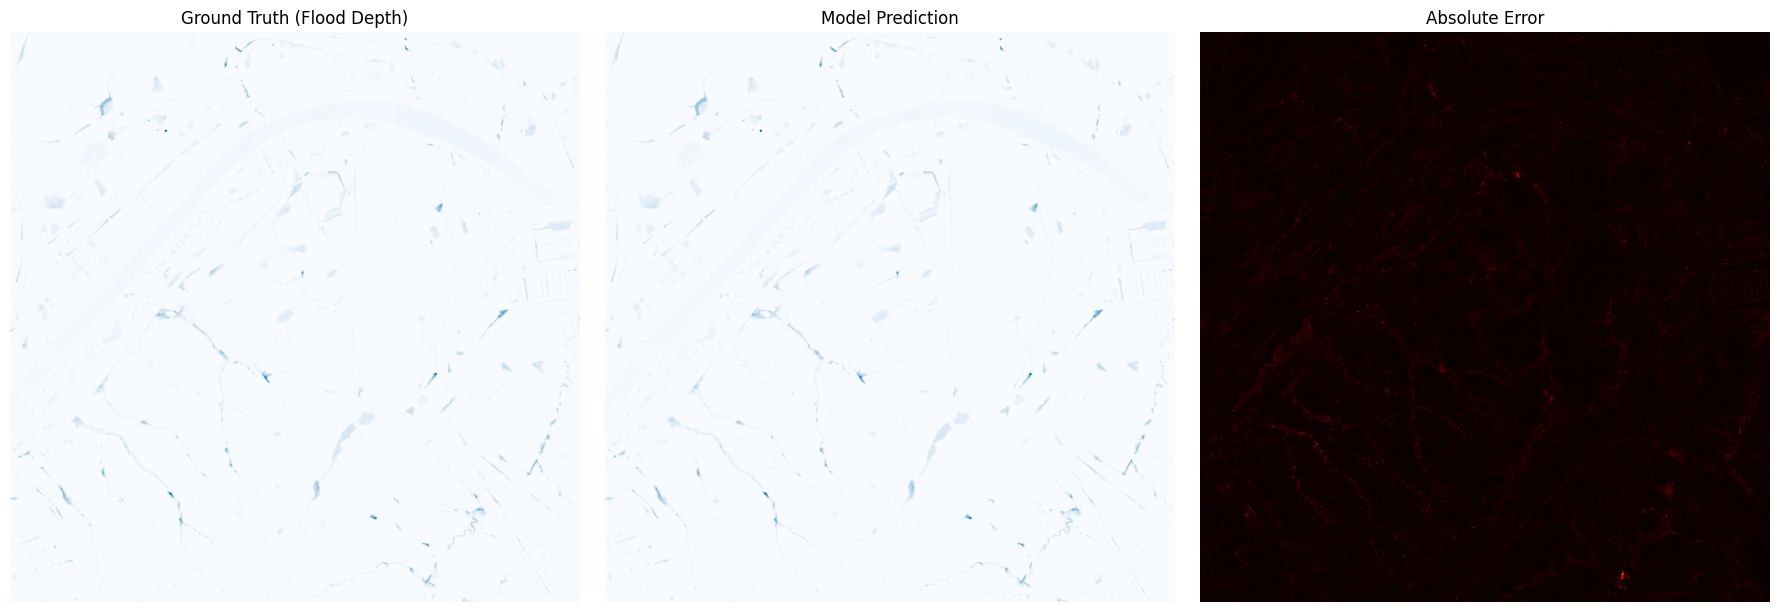

In [2]:
# Get the same input used during training
val_sample = next(iter(train_dataset))  # Already cached/repeated, returns the same one

val_input = val_sample[0]
val_gt = val_sample[1].numpy().squeeze()  # shape: (H, W)
val_pred = model.call(val_input).numpy().squeeze()  # shape: (H, W)
#val_pred = model.call(val_sample[0])
print("Prediction stats:", tf.reduce_min(val_pred).numpy(), tf.reduce_max(val_pred).numpy(), tf.reduce_mean(val_pred).numpy())
import matplotlib.pyplot as plt
import numpy as np

vmax_val = max(val_gt.max(), val_pred.max())  # auto scale color

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(val_gt, cmap="Blues", vmin=0, vmax=vmax_val)
plt.title("Ground Truth (Flood Depth)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(val_pred, cmap="Blues", vmin=0, vmax=vmax_val)
plt.title("Model Prediction")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(val_gt - val_pred), cmap="hot")
plt.title("Absolute Error")
plt.axis("off")

plt.tight_layout()
plt.show()



In [3]:
print(f"MAE: {np.mean(np.abs(val_gt - val_pred))}")
print(f"RMSE: {np.sqrt(np.mean((val_gt - val_pred) ** 2))}")


MAE: 0.004148615524172783
RMSE: 0.008207838982343674


In [ ]:
for val_sample in train_dataset_full.take(3):
    val_input = val_sample[0]
    val_gt = val_sample[1].numpy()
    val_pred = tf.squeeze(model.call(val_input), axis=-1).numpy()

    mae = mean_absolute_error(val_gt.flatten(), val_pred.flatten())
    rmse = np.sqrt(np.mean((val_gt.flatten() - val_pred.flatten())**2))
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(val_gt[0], cmap='Blues')
    plt.title("GT")

    plt.subplot(1, 3, 2)
    plt.imshow(val_pred[0], cmap='Blues')
    plt.title("Prediction")

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(val_pred[0] - val_gt[0]), cmap='hot')
    plt.title("Error")
    plt.tight_layout()
    plt.show()


In [ ]:
print("Mean GT:", val_gt.mean(), "Mean Pred:", val_pred.mean())

In [ ]:
plt.hist(val_pred.flatten(), bins=100)

In [ ]:
val_sample = next(iter(train_dataset))

# === Unpack validation input/output ===
val_input = val_sample[0]
val_gt = val_sample[1]  # shape: (batch, H, W)
val_pred = model.call(val_input)  # shape: (batch, H, W, 1)

# Remove channels dimension from prediction
val_pred = tf.squeeze(val_pred, axis=-1).numpy()  # shape: (batch, H, W)
val_gt = val_gt.numpy()

# === Compute metrics across all batch samples ===
mae_list = []
rmse_list = []
binary_acc_list = []

threshold = 0.01
batch_size = val_gt.shape[0]

for i in range(batch_size):
    gt = val_gt[i]
    pred = val_pred[i]

    # Compute MAE and RMSE
    mae = mean_absolute_error(gt.flatten(), pred.flatten())
    rmse = np.sqrt(np.mean((gt.flatten() - pred.flatten())**2))
    mae_list.append(mae)
    rmse_list.append(rmse)

    # Threshold maps
    gt_bin = (gt > threshold).astype(np.uint8)
    pred_bin = (pred > threshold).astype(np.uint8)

    # Binary accuracy
    correct = (gt_bin == pred_bin).sum()
    total = gt_bin.size
    binary_acc = correct / total
    binary_acc_list.append(binary_acc)

# === Report aggregate metrics ===
print(f"Average MAE over batch: {np.mean(mae_list):.4f}")
print(f"Average RMSE over batch: {np.mean(rmse_list):.4f}")
print(f"Average Binary Accuracy: {np.mean(binary_acc_list):.4f}")

# Optional: Show basic stats for first few samples
print("GT max:", np.max(val_gt))
print("GT min:", np.min(val_gt))
print("Prediction max:", np.max(val_pred))
print("Prediction min:", np.min(val_pred))
print("GT mean:", np.mean(val_gt))
print("GT unique values (sample):", np.unique(val_gt[0]))

# === Visualization for first few samples ===
num_samples = min(10, batch_size)  # visualize up to 3 samples
for i in range(num_samples):
    gt = val_gt[i]
    pred = val_pred[i]

    print(f"\nSample {i}")
    print("GT max:", np.max(gt), "GT min:", np.min(gt))
    print("Prediction max:", np.max(pred), "Prediction min:", np.min(pred))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(gt, cmap="Blues", vmin=0, vmax=0.08)
    axs[0].set_title(f"GT Flood Map #{i}")
    axs[1].imshow(pred, cmap="Blues", vmin=0, vmax=0.08)
    axs[1].set_title(f"Prediction #{i}")
    axs[2].imshow(np.abs(gt - pred), cmap="hot")
    axs[2].set_title("Error Map")
    plt.tight_layout()
    plt.show()
